# Proyecto: Predicción de patrones en series de tiempo (univariadas) usando Redes Neuronales Recurrentes

En la presente práctica veremos que la predicción de patrones en series de tiempo de puede realizar mediante un entrenamiento supervisado en donde los features y labels se construyen con los datos de la serie de tiempo.

Veremos que para poder realizar predicciones a largo plazo es necesario que las componentes de cada feature contenga un alto porcentaje de los datos de la serie de tiempo.

Veremos que una red recurrente es capás de generar nuevos features a partir de un "feature raíz".

En esta práctica usaremos una red Feed Forward y los features que pasaran por la red serán tensores 2D: (m,n) [m features, cada uno de tamaño (n,)]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

import seaborn as sns
from scipy import stats

# importamos funciones para construir redes neuronales:
from tensorflow.keras import layers, models, optimizers, regularizers

from sklearn.preprocessing import MinMaxScaler

# Parámetros para graficación
#%matplotlib inline
#plt.rcParams['figure.figsize'] = (15, 5)
#plt.style.use('fast')

In [2]:
# Cargamos datos:
# usamos 'header=None' ya que el dataset viene sin encabezado
df = pd.read_csv('./Data/non_lin_data_1D.csv')
#df = pd.read_csv('./Data/time_series.csv',header=None)
df

,x,y
0,0,11.191186
1,1,11.292703
2,2,12.138801
3,3,8.692781
4,4,11.384937
...,...,...
995,995,3.019262
996,996,4.753131
997,997,5.323600
998,998,6.349841


In [3]:
# Eliminamos la columna 'x', pues en esta caso solo nos interesa la columna 'y'
df.drop(columns=['x'],inplace=True)

df

,y
0,11.191186
1,11.292703
2,12.138801
3,8.692781
4,11.384937
...,...
995,3.019262
996,4.753131
997,5.323600
998,6.349841


In [4]:
# Extraemos información de las variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       1000 non-null   float64
dtypes: float64(1)
memory usage: 7.9 KB


In [5]:
# Extraemos información estadística de los datos:
df.describe()

,y
count,1000.000000
mean,4.870888
std,3.631517
min,-2.405493
25%,1.563608
50%,4.760117
75%,8.183265
max,12.910212


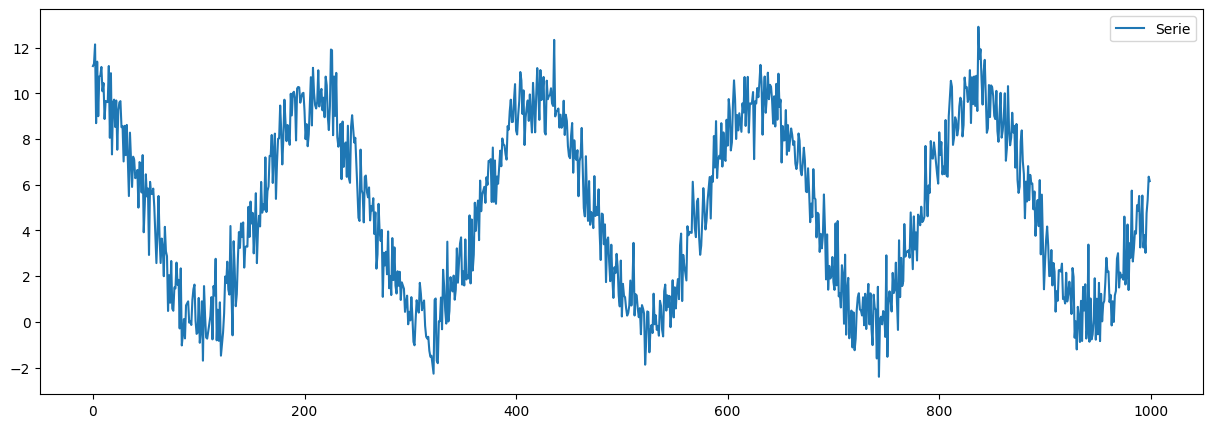

In [6]:
plt.figure(figsize=(15,5))
plt.plot(df['y'] , label = 'Serie')
plt.legend()
plt.show()

## Tratamiento de Outliers:

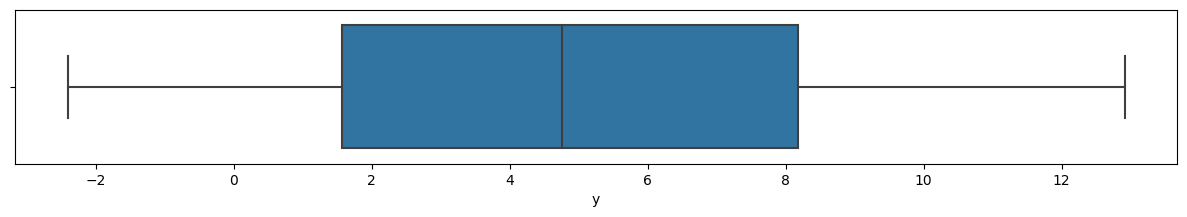

In [7]:
# Usamos un gráfico de caja y bigotes para detectar "outliers" (valores atípicos):
plt.figure(figsize=(15,2))
sns.boxplot(x=df['y'])
plt.show()

En la gráfica anterior podemos notar que el dataset esta libre de outliers

## A continuación preparamos los datos que usaremos para entrenar un modelo que realizará la predicción del patrón en la serie de datos:

### Como modelo usaremos una Red Neuronal (Feed Forward) cuya capa de salida no tendrá función de activación (tal como en los casos de regresión), sin embargo en las capas internas usaremos la función de activación `ReLu` que toma valores entre [0,+inf] así que reescalaremos los datos entre [0,1].

In [8]:
# Reescalamos los datos entre [0,1] usando la función 'MinMaxScaler':

scaler = MinMaxScaler(feature_range=(0, 1))

scaled_vals = scaler.fit_transform(df)
scaled_vals.shape

(1000, 1)

Otra forma de reescalar los datos es mediante la creación de una transformación lineal que lleva [x0,x1]->[y0,y1]:

```
def linear_T(x,x0,x1,y0,y1):
    m = (y1-y0)/(x1-x0)
    return m*(x-x0) + y0
```

## Construimos Features y Labels a partir de la serie:

Inicialmente la serie de tiempo es de la forma: [x1, x2, x3, x4, x5, x6, x7, x8, x9, ...]

De dicha serie de tiempos construimos el conunto de features y labels para entrenar un modelo supervisado.

Construimos los features usando los primeros `n` registros y el label correspondiente será el siguiente registro `n+1`:

Por ejmplo:

x1, x2, x3, |x4

x2, x3, x4, |x5

x3, x4, x5, |x6 ...

Feature 1 = [x1, x2, x3]; Label 1 = x4 

Feature 2 = [x2, x3, x4]; Label 2 = x5

Feature 3 = [x3, x4, x5]; Label 3 = x6 

y así susesivamente.

In [9]:
# Definimos la función que creará los features y labels que consumirá la red neuronal:
def split_sequence( n_steps , sequence ):
    N = len(sequence)    
    X, Y = [], []
    for i in range( N ):
        end_Xi = i + n_steps
        if end_Xi > N - 1:
            break
        seq_Xi = sequence[i:end_Xi]
        Yi = sequence[end_Xi]

        X.append(seq_Xi)
        Y.append(Yi)

    return np.array(X), np.array(Y)

In [10]:
p_d = 0.2 #<-- porcentaje de datos que se tomaran para construir cada feature

# No. de componentes para cada feature:
n_comp = round( p_d*len(df) )

print('Cada feature consta de',n_comp,'componentes que corresponde a un',p_d*100,'% de los datos')

Cada feature consta de 200 componentes que corresponde a un 20.0 % de los datos


### Obs: Entre más grande sea el número de componentes de cada feature podremos hacer predicciones a largo plazo. Hay que tener cuidado que el número de componentes de cada feature sea más pequeño el número de datos de validación

In [11]:
# Construimos features y labels:
x_features , y_labels = split_sequence(n_comp , scaled_vals)

In [12]:
x_features = x_features[:,:,0]

In [13]:
x_features.shape

(800, 200)

In [14]:
# Visualizamos los features en un Data Frame
pd.DataFrame(x_features)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.887761,0.894389,0.949633,0.724634,0.900411,0.744538,0.858067,0.859994,0.885244,0.815774,...,0.814336,0.796017,0.675274,0.823704,0.828041,0.826731,0.783192,0.799057,0.809477,0.811215
1,0.894389,0.949633,0.724634,0.900411,0.744538,0.858067,0.859994,0.885244,0.815774,0.839081,...,0.796017,0.675274,0.823704,0.828041,0.826731,0.783192,0.799057,0.809477,0.811215,0.759817
2,0.949633,0.724634,0.900411,0.744538,0.858067,0.859994,0.885244,0.815774,0.839081,0.736416,...,0.675274,0.823704,0.828041,0.826731,0.783192,0.799057,0.809477,0.811215,0.759817,0.679054
3,0.724634,0.900411,0.744538,0.858067,0.859994,0.885244,0.815774,0.839081,0.736416,0.788084,...,0.823704,0.828041,0.826731,0.783192,0.799057,0.809477,0.811215,0.759817,0.679054,0.721833
4,0.900411,0.744538,0.858067,0.859994,0.885244,0.815774,0.839081,0.736416,0.788084,0.785351,...,0.828041,0.826731,0.783192,0.799057,0.809477,0.811215,0.759817,0.679054,0.721833,0.658691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.669597,0.641688,0.608937,0.578547,0.551895,0.698452,0.633996,0.670688,0.578294,0.600472,...,0.416293,0.408797,0.490342,0.474390,0.516639,0.369527,0.434636,0.517774,0.369329,0.404555
796,0.641688,0.608937,0.578547,0.551895,0.698452,0.633996,0.670688,0.578294,0.600472,0.579214,...,0.408797,0.490342,0.474390,0.516639,0.369527,0.434636,0.517774,0.369329,0.404555,0.354196
797,0.608937,0.578547,0.551895,0.698452,0.633996,0.670688,0.578294,0.600472,0.579214,0.733562,...,0.490342,0.474390,0.516639,0.369527,0.434636,0.517774,0.369329,0.404555,0.354196,0.467404
798,0.578547,0.551895,0.698452,0.633996,0.670688,0.578294,0.600472,0.579214,0.733562,0.574024,...,0.474390,0.516639,0.369527,0.434636,0.517774,0.369329,0.404555,0.354196,0.467404,0.504651


In [15]:
# Visualizamos los labels en un Data Frame
pd.DataFrame(y_labels)

,0
0,0.759817
1,0.679054
2,0.721833
3,0.658691
4,0.691977
...,...
795,0.354196
796,0.467404
797,0.504651
798,0.571657


## Construcción de datos de entrenamiento y validación:

Debido a que en las series de tiempo, el orden sí importa, debemos particionar los datos conservando el orden.

In [16]:
p_val = p_d + 0.05 # <-- porcentaje de datos de validación (debe ser mayor que el número de componetes en cada feature)
print('Tomamos un',p_val*100,'% de los datos para validación')
print('correspondiente a los últimos',round( p_val*len(df) ),'días registrados')


if p_val > p_d:
    # índice límite para extraer datos de entrenamiento:
    j = len(df) - round( p_val*len(df) )

    # Features de entrenamiento y validación
    x_train = x_features[:j , :]
    x_val = x_features[j: , :]

    # Labels de entrenamiento y validación
    y_train = y_labels[:j]
    y_val = y_labels[j:]

else:
    print("Error! El número de componetes de cada feature debe ser menor que los datos de validación")
    stop
    

Tomamos un 25.0 % de los datos para validación
correspondiente a los últimos 250 días registrados


In [17]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(750, 200)
(50, 200)
(750, 1)
(50, 1)


In [18]:
# Extraemos la dimensión de cada feature:
dim_feature = x_train[0].shape
dim_feature

(200,)

## Construimos la Red Neuronal:

In [19]:
def build_model(dim_feature , lr):
    # Construimos arquitectura de la red:
    model = models.Sequential()

    # Número de neuronas en cada capa:
    nn = 50
    
    # Capa (entrada)
    model.add( layers.Dense(nn, activation='relu', input_shape=dim_feature ))
    
    # Capa oculta 1
    model.add( layers.Dense(nn, activation='relu' ) )

    # Capa oculta 2
    model.add( layers.Dense(nn, activation='relu', kernel_regularizer=regularizers.l1_l2(0.002,0.002) ) )
    #model.add( layers.Dropout(0.3) ) # hacemos "dropout" a la capa anterior

    # Capa oculta 3
    model.add( layers.Dense(nn, activation='relu' ) )

    # Capa de salida (una sóla neurona con función de activación 'tanh')
    #model.add( layers.Dense(1, activation='tanh') )    
    # Capa de salida (una sóla neurona sin función de activación)
    model.add( layers.Dense(1) )

    # visualzamos la arquitecura de la red:
    # model.summary()

    # optimizador:
    optim_meth = optimizers.Nadam(learning_rate=lr)

    # compilamos la red:
    model.compile(
        optimizer= optim_meth,
        loss='mse',  # <-- Función de costo a minimizar: mean square error (para problemas de regresión)
        #metrics='mae'# <-- Métrica para evaluar entrenamiento: mean absolute error
        )

    return model

In [20]:
# ================= Parámetros que controlan la convergencia de la red =====================
# learning rate:
lr = 0.001

n_epochs = 300

n_batch_size = round(0.02*x_train.shape[0])#n_comp
n_batch_size
# ===========================================================================================

15

In [ ]:
# Declaramos la red neuronal:
model = build_model(dim_feature , lr)

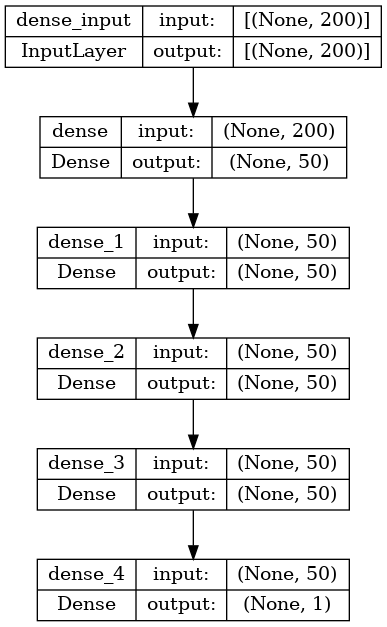

In [22]:
# Generamos un grafico sobre la arquitectura de la red:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='modelo.png', show_shapes = True)

In [23]:
# Entrenamos la red:   
training = model.fit(
    x_train,
    y_train,
    epochs=n_epochs,
    batch_size =n_batch_size,
    validation_data = (x_val,y_val),
    verbose=0 # 1 --> muestra el proceso de entrenamiento
)

In [24]:
# Extraemos las curvas de 'loss' y 'accuracy' para los datos de entrenamiento y validacion: 
loss_train_curve = training.history['loss']
loss_valid_curve = training.history['val_loss']

#accu_train_curve = training.history['mae']
#accu_valid_curve = training.history['val_mae']

Text(0.5, 0, 'epoch')

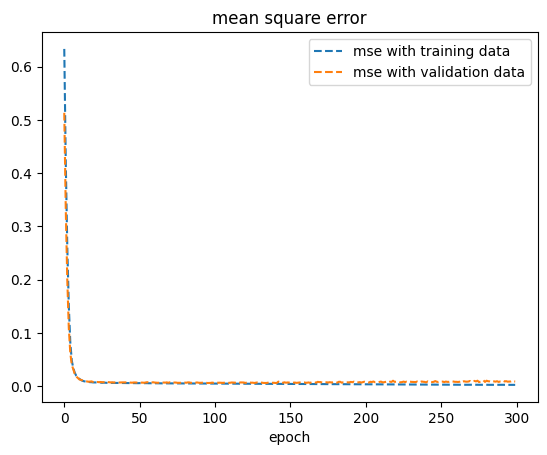

In [25]:
# Graficamos curvas:

# Eje x:
epoch = range( n_epochs )

#plt.subplot(1,2,1)
plt.plot(epoch, loss_train_curve, '--', label='mse with training data')
plt.plot(epoch, loss_valid_curve, '--', label='mse with validation data')
plt.legend()
plt.title('mean square error')
plt.xlabel('epoch')

#plt.subplot(1,2,2)
#plt.plot(epoch, accu_train_curve, label='mae with training data')
#plt.plot(epoch, accu_valid_curve, label='mae with validation data')
#plt.legend()
#plt.title('mean absolute error')
#plt.xlabel('epoch')
#plt.show()

In [26]:
model.evaluate(x_val, y_val)

2/2 [==============================] - 0s 3ms/step - loss: 0.0087


0.008699730969965458

In [27]:
# Hacemos predicciones con el modelo entrenado: 
y_val_pred=model.predict(x_val)

2/2 [==============================] - 0s 3ms/step


In [28]:
y_val_pred.shape

(50, 1)

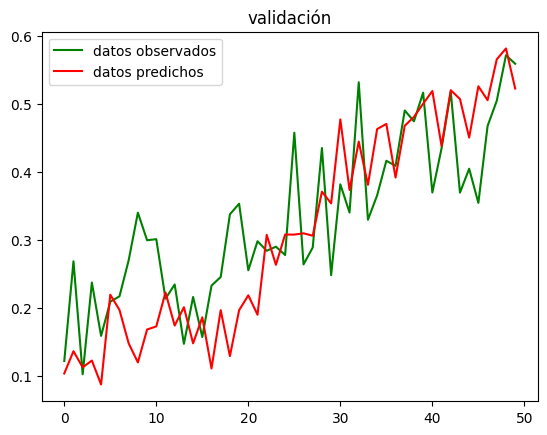

In [29]:
plt.plot(range(len(y_val)) ,y_val,c='g',label = 'datos observados')
plt.plot(range(len(y_val_pred)),y_val_pred,c='r', label = 'datos predichos')
plt.title('validación')
plt.legend()
plt.show()

## Pronóstico de valores futuros:

Para predecir valores a futuro, debemos construir el "feature raíz" a partir del cual se construiran los valores futuros.
El "feature raíz" se construye con los últimos registros de la serie de tiempo.

In [30]:
df.index.max()

999

In [31]:
# Extraemos los últimos 'n_last' registros para construir el "feature raíz" a partir del cual
# se construirán las predicciones 

n_last = df.index.max() - n_comp - 1

df_last = df.loc[ n_last :]
df_last

,y
798,6.455360
799,6.047168
800,8.291793
801,7.304603
802,7.866571
...,...
995,3.019262
996,4.753131
997,5.323600
998,6.349841


In [32]:
# Reescalamos los datos entre [0,1]:
scaled_vals_last = scaler.fit_transform(df_last)
scaled_vals_last.shape

(202, 1)

In [33]:
# Construimos features y labels con los datos de la serie anterior:
x_features2 , y_labels2 = split_sequence(n_comp,scaled_vals_last)

In [34]:
x_features2 = x_features2[:,:,0]

In [35]:
x_features2.shape

(2, 200)

In [36]:
# Visualizamos los features en un Data Frame
pd.DataFrame(x_features2)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.542853,0.513944,0.672913,0.602998,0.642798,0.542578,0.566635,0.543577,0.710997,0.537947,...,0.429875,0.475702,0.316131,0.386754,0.476933,0.315917,0.354125,0.299501,0.422297,0.462699
1,0.513944,0.672913,0.602998,0.642798,0.542578,0.566635,0.543577,0.710997,0.537947,0.535269,...,0.475702,0.316131,0.386754,0.476933,0.315917,0.354125,0.299501,0.422297,0.462699,0.535380


In [37]:
# Del conjunto anterior 'x_features2' tomamos el último renglón, 
# pués a partir de dicho feature iniciaremos la predicción de valores
x_test = x_features2[-1]
x_test.shape

(200,)

In [ ]:
# Iniciamos la predicción de la serie de tiempo

# No. de días a predecir:
n_days = 365

# Redimensionamos feature para que pase por la red entrenada:
xi = x_test.reshape(1,len(x_test))

list_pred=[]
for i in range(n_days):

    # Obtenemos la predicción del feature 'xi':
    yi = model.predict(xi)
    #print(yi)

    # Construimos feature para la siguiente predicción:
    xi = np.concatenate([xi[:,1:],yi], axis=1)
    #print(xi)

    # Vamos guardando predicciones en la lista 'list_pred':
    list_pred.append( yi[0][0] )

# Guardamos la lista en un arreglo de numpy:
y_new = np.array(list_pred)
y_new


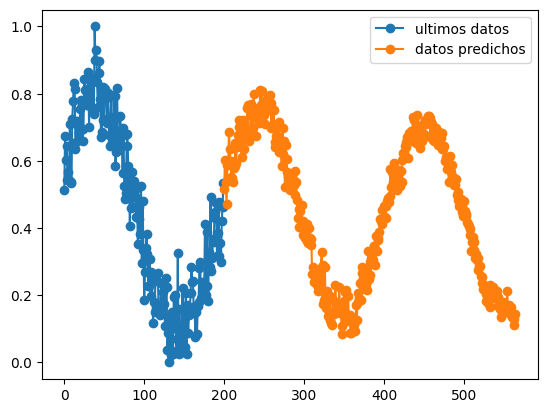

In [39]:
p = len(x_test)
q = len(y_new)

plt.plot( range(p), x_test,'o-',label='ultimos datos')
plt.plot( range(p,p+q), y_new,'o-',label='datos predichos')
plt.legend()
plt.show()

## Debido a que las predicciones se hicieron con datos reescalados en [0,1], invertimos el reescalado para obtener las predicciones en el dominio de los datos reales 


In [ ]:
# Redimensionamos 'y_new' como array 2D para aplicarle la transformación inversa del reescalado:
y_new = y_new.reshape( q,1 )

# Obtenemos el pronóstico de la serie de tiempo real:
y_pronostic = scaler.inverse_transform(y_new)
y_pronostic

In [41]:
p = len(df_last)
q = len(y_pronostic)

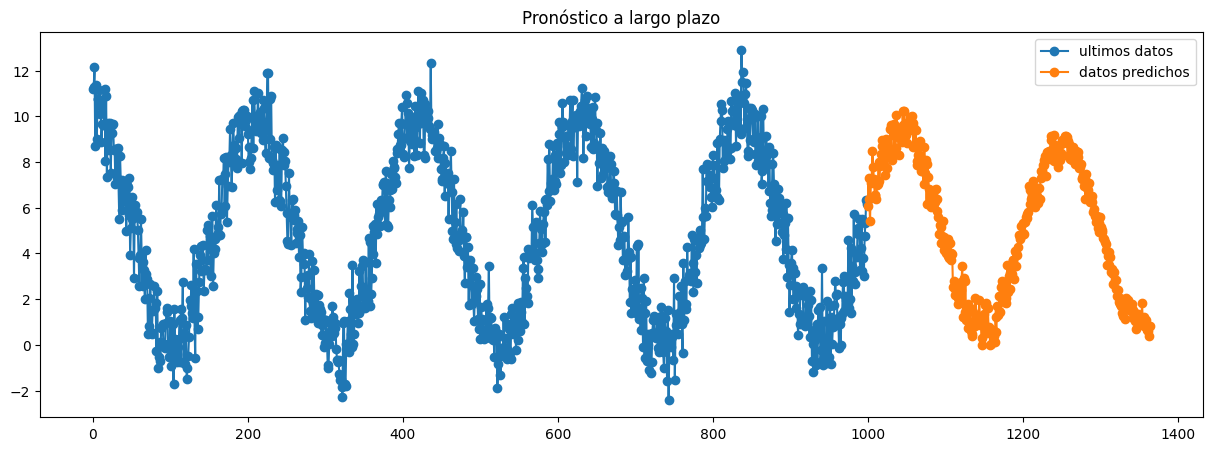

In [42]:
df_last = df#.loc[ df.index.max()-500 :]

p = len(df_last)
q = len(y_pronostic)

plt.figure(figsize=(15,5))
plt.plot( range(p), df_last,'o-',label='ultimos datos')
plt.plot( range(p,p+q), y_pronostic,'o-',label='datos predichos')
plt.title('Pronóstico a largo plazo')
plt.legend()
plt.show()